In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Thu Jan 18 14:01:14 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    68W / 300W |   8431MiB / 80994MiB |      9%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.20it/s]

-2.929292929292929


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0587], device='cuda:0', grad_fn=<ExpBackward0>)


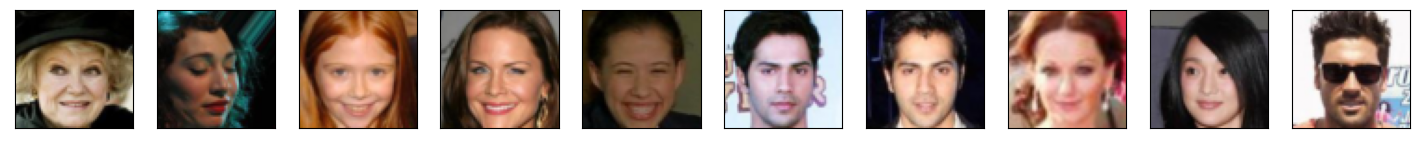

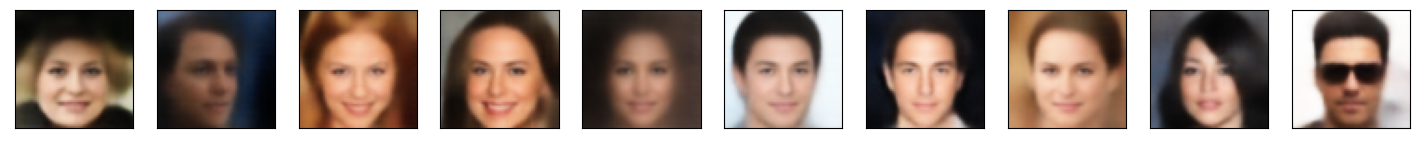

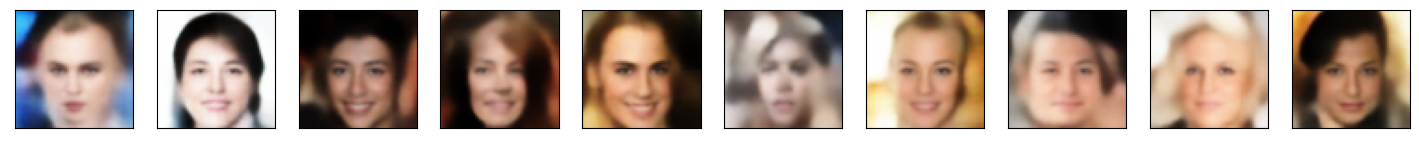

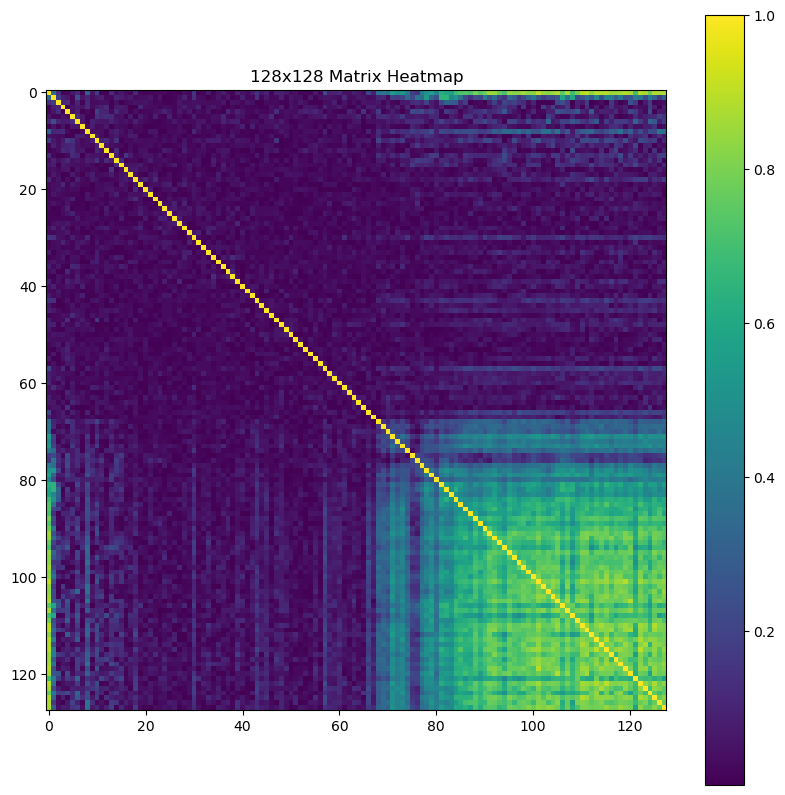

13001
lse_loss -0.671587347984314
recon_loss 0.01032087579369545
13002
lse_loss -0.6752166748046875
recon_loss 0.010065646842122078
13003
lse_loss -0.6735314130783081
recon_loss 0.011298644356429577
13004
lse_loss -0.6740469932556152
recon_loss 0.009201164357364178
13005
lse_loss -0.6734622716903687
recon_loss 0.010455060750246048
13006
lse_loss -0.6746188402175903
recon_loss 0.009453581646084785
13007
lse_loss -0.6736823916435242
recon_loss 0.009325372986495495
13008
lse_loss -0.6729152798652649
recon_loss 0.012341475114226341
13009
lse_loss -0.6735044121742249
recon_loss 0.01040362473577261
13010
lse_loss -0.6715240478515625
recon_loss 0.01000406313687563
13011
lse_loss -0.6738507747650146
recon_loss 0.009956324473023415
13012
lse_loss -0.6723175048828125
recon_loss 0.010781186632812023
13013
lse_loss -0.6740463376045227
recon_loss 0.009628145024180412
13014
lse_loss -0.6744471788406372
recon_loss 0.01066514290869236
13015
lse_loss -0.672875165939331
recon_loss 0.009709729813039303
1

13124
lse_loss -0.6711990833282471
recon_loss 0.009500265121459961
13125
lse_loss -0.6744204759597778
recon_loss 0.00966893881559372
13126
lse_loss -0.6724961400032043
recon_loss 0.01024993322789669
13127
lse_loss -0.6753348112106323
recon_loss 0.009160327725112438
13128
lse_loss -0.6732165813446045
recon_loss 0.0105122160166502
13129
lse_loss -0.6724936962127686
recon_loss 0.009785734117031097
13130
lse_loss -0.6730775833129883
recon_loss 0.009756531566381454
13131
lse_loss -0.6764592528343201
recon_loss 0.009537968784570694
13132
lse_loss -0.6730417609214783
recon_loss 0.009951397776603699
13133
lse_loss -0.6726392507553101
recon_loss 0.008622638881206512
13134
lse_loss -0.6733458638191223
recon_loss 0.010322149842977524
13135
lse_loss -0.6724985241889954
recon_loss 0.008953864686191082
13136
lse_loss -0.6741055846214294
recon_loss 0.009134560823440552
13137
lse_loss -0.6755377054214478
recon_loss 0.010213515721261501
13138
lse_loss -0.6719127893447876
recon_loss 0.00936736911535263


13247
lse_loss -0.6734595894813538
recon_loss 0.010387476533651352
13248
lse_loss -0.6731678247451782
recon_loss 0.009280537255108356
13249
lse_loss -0.6738630533218384
recon_loss 0.008943833410739899
13250
lse_loss -0.671271800994873
recon_loss 0.009855380281805992
13251
lse_loss -0.6727858185768127
recon_loss 0.010179275646805763
13252
lse_loss -0.6724505424499512
recon_loss 0.010702492669224739
13253
lse_loss -0.6723417043685913
recon_loss 0.010545159690082073
13254
lse_loss -0.6733576059341431
recon_loss 0.010410397313535213
13255
lse_loss -0.6699623465538025
recon_loss 0.009836193174123764
13256
lse_loss -0.6710946559906006
recon_loss 0.00986464787274599
13257
lse_loss -0.6705023050308228
recon_loss 0.010667731985449791
13258
lse_loss -0.6728471517562866
recon_loss 0.01051213126629591
13259
lse_loss -0.6747609972953796
recon_loss 0.010957468301057816
13260
lse_loss -0.6737070679664612
recon_loss 0.009120715782046318
13261
lse_loss -0.6710776090621948
recon_loss 0.01065539009869098

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-2
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
    
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
            
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(data['z_copy'])*2-1)
            mmd = mmd_penalty(data['z_copy'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [15]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


In [18]:
data['z_copy']

torch.Size([256, 128])

In [24]:
from util.mmd_penalty import mmd_penalty
opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'normal', # 'normal', 'sphere', 'uniform' 
        'zdim': hp.z_dim
       } 
e = (torch.rand_like(data['z_copy'])*2-1)
mmd = mmd_penalty(data['z_copy'], e, opts).item()
writer.add_scalar('MMD', mmd, step)